## Data Understanding: Exploring the Dataset

This notebook will explore the Credit Card Transactions dataset to identify potential feature issues fulfilling the Data Understanding phase of the CRISP-DM project planning framework. 

### Objectives:
1. **Understand the Dataset**: Gain familiarity with the dataset structure, including feature types, distributions, and relationships.
2. **Identify Potential Issues**:
   - Missing or incomplete data
   - Outliers or anomalies
   - Features that may require transformation 
3. **Document Observations**: Note any data quality issues and potential corrective actions.

The aim is to clearly understand the dataset and necessary preprocessing steps, ensuring readiness for the feature engineering and modeling stages.

In [1]:
#loading libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from geodatasets import get_path
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz, process
%matplotlib inline

C:\Users\eelil\.conda\envs\Machine_Learning_Analysis_of_Bank_Fraud\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\eelil\.conda\envs\Machine_Learning_Analysis_of_Bank_Fraud\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\eelil\.conda\envs\Machine_Learning_Analysis_of_Bank_Fraud\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
#path to local csv file
data = 'data/1/credit_card_transactions.csv'

#making dataframe
df = pd.read_csv(data)

I am working with a local copy of the CSV file instead of accessing the wandb artifact to ensure that any changes made during the data understanding phase remain temporary and do not affect the original data. When I start on the preprocessing and feature creation phase, I will access the wandb artifact. Additionally, I am not incorporating logging into this file, as this notebook will serve as my log for this phase.

In [3]:
#viewing the first 5 rows of data
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [4]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')

### Column Descriptions and Initial Observations

The dataset contains the following columns:

1. **Unnamed**: Original index column, redundant in this analysis.
2. **trans_date_trans_time**: Timestamp of the transaction.
3. **cc_num**: Credit card number (hashed/anonymized).
4. **merchant**: Merchant or store where the transaction occurred.
5. **category**: Type of transaction.
6. **amt**: Amount of the transaction.
7. **first**: First name of the cardholder.
8. **last**: Last name of the cardholder.
9. **gender**: Gender of the cardholder.
10. **street**: Address details of the cardholder.
11. **city**: Address details of the cardholder.
12. **state**: Address details of the cardholder.
13. **zip**: Address details of the cardholder.
14. **lat**: Geographical coordinates of the transaction.
15. **long**: Geographical coordinates of the transaction.
16. **city_pop**: Population of the city where the transaction occurred.
17. **job**: Occupation of the cardholder.
18. **dob**: Date of birth of the cardholder.
19. **trans_num**: Unique transaction number.
20. **unix_time**: Unix timestamp of the transaction.
21. **merch_lat**: Geographical coordinates of the merchant.
22. **merch_long**: Geographical coordinates of the merchant.
23. **is_fraud**: Indicator of whether the transaction is fraudulent.
24. **merch_zipcode**: Zip code of the merchant.

**Please note, these column descriptions are taken directly from [Kaggle](https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset) (Choksi, n.d.).**    

Based on the column descriptions and the initial inspection of the data (first five rows of the dataframe), the following columns will be removed:

1. **Unnamed**: This column served as the original index and is redundant.

2. **first**, **last**, **gender**, **street**, **zip**, **merch_zipcode**:
   - **first** and **last** are not necessary for analysis, as the credit card number (`cc_num`) already identifies the account.
   - **gender** is unlikely to contribute to identifying fraudulent transactions and could introduce bias or discrimination into the model.
   - **unix_time** will be dropped if 'trans_data_trans_time' is complete.
   - **street** is too specific for this project. I will be using city and state for customer's location.
   - **zip**, **merch_zipcode** will be dropped for redundency if other location based columns are complete.

**trans_num** will be retained to prevent identical values in other columns from mistakenly flagged as duplicates, and won't be adjusted unless there are duplicate values.  


In [5]:
#dropping unnamed column
df.drop(df.columns[df.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)

In [6]:
#dropping 'first', 'last', and 'gender'
df.drop(['first', 'last', 'gender'], axis=1, inplace=True)

In [7]:
#checking the number of records and columns
df.shape

(1296675, 20)

In [8]:
#dropping any duplicate rows
df.drop_duplicates(inplace=True)
#checking if the number of records changed
df.shape

(1296675, 20)

There were no duplicates in this dataset. However, I will add duplicate-checking in the data preparation phase to accommodate future datasets.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   street                 1296675 non-null  object 
 6   city                   1296675 non-null  object 
 7   state                  1296675 non-null  object 
 8   zip                    1296675 non-null  int64  
 9   lat                    1296675 non-null  float64
 10  long                   1296675 non-null  float64
 11  city_pop               1296675 non-null  int64  
 12  job                    1296675 non-null  object 
 13  dob                    1296675 non-null  object 
 14  trans_num         

In [10]:
#dropping redundant columns
df.drop(['street', 'zip', 'merch_zipcode', 'unix_time'], axis=1, inplace=True)

### Based on the datatypes and null values:

**Location Columns**
Due to redundancy, several location columns ('street,' 'zip,' 'merch_zipcode) were dropped. 
- The latitude and longitude columns for merchants are complete and will be utilized in the next phase for merchant location, resulting in 'merch_zipcode' being dropped. This also removed all null values from the dataframe.
- The 'street' column was dropped since 'city' and 'state' will represent the customer's location.

**Unix Time Column**
The 'unix_time' column was dropped for redundancy since 'trans_date_trans_time' is complete. I intend to make several new datetime columns.

**Columns with Unusual Data Types** 
- trans_date_trans_time  |  object 
- merchant               |  object 
- category               |  object 
- city                   |  object   
- state                  |  object  
- job                    |  object  
- dob                    |  object  
- is_fraud               |  int64    


Will be changed to: 
1. **'trans_data_trans_time', 'dob'** - datetime
2. **'merchant', 'category', 'city', 'state', 'job', 'is_fraud'** - category

In [11]:
#number of unique values in each column
df.nunique()

trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
city                         894
state                         51
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64

In [12]:
#changing data types of some columns for easier plotting
#first the datetime columns
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1296675 entries, 0 to 1296674
Series name: trans_date_trans_time
Non-Null Count    Dtype         
--------------    -----         
1296675 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 9.9 MB


In [13]:
df['dob'] = pd.to_datetime(df['dob'])
df['dob'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1296675 entries, 0 to 1296674
Series name: dob
Non-Null Count    Dtype         
--------------    -----         
1296675 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 9.9 MB


In [14]:
#now the category columns
df[['category', 'merchant', 'job', 'is_fraud', 'state', 'city']] = df[['category', 'merchant', 'job', 'is_fraud', 'state', 'city']].astype('category')
df[['category', 'merchant', 'job', 'is_fraud', 'state', 'city']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   category  1296675 non-null  category
 1   merchant  1296675 non-null  category
 2   job       1296675 non-null  category
 3   is_fraud  1296675 non-null  category
 4   state     1296675 non-null  category
 5   city      1296675 non-null  category
dtypes: category(6)
memory usage: 11.2 MB


In [15]:
#checking data types before plotting
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 16 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  category      
 3   category               1296675 non-null  category      
 4   amt                    1296675 non-null  float64       
 5   city                   1296675 non-null  category      
 6   state                  1296675 non-null  category      
 7   lat                    1296675 non-null  float64       
 8   long                   1296675 non-null  float64       
 9   city_pop               1296675 non-null  int64         
 10  job                    1296675 non-null  category      
 11  dob                    1296675 non-null  datetime64[ns]
 12  trans_num              12966

## Column Analysis

### Column - 'is_fraud'

In [16]:
#grouping fraud accounts
fraud = df.groupby('is_fraud', observed=True)

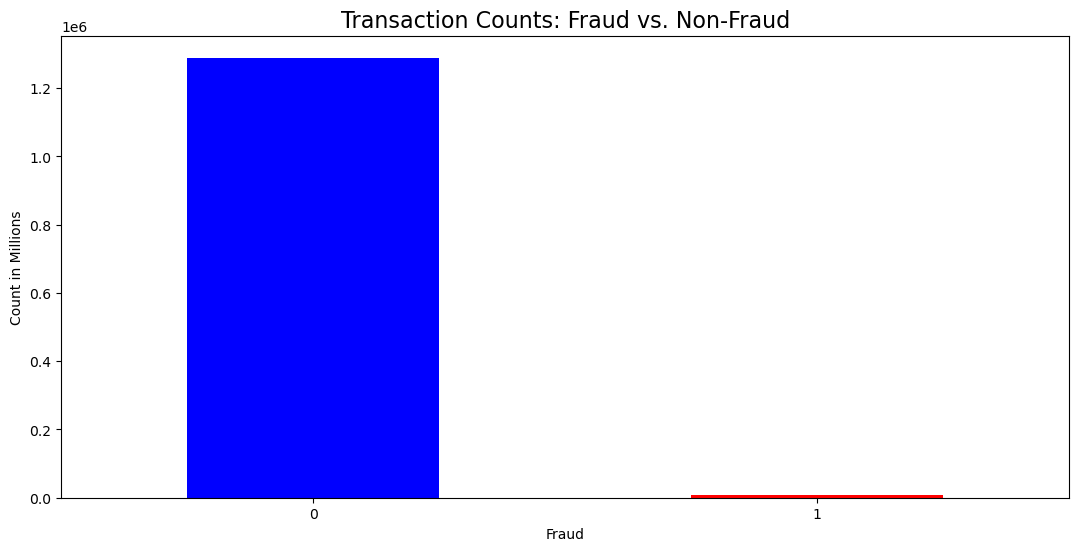

In [17]:
#visualizing what portion of the data is fraudulent transactions
fraud_counts = fraud.size()
ax = fraud_counts.plot(kind='bar', rot=0,  color=['blue', 'red'], figsize=(13,6))

plt.xlabel('Fraud')
plt.ylabel('Count in Millions')
ax.set_title('Transaction Counts: Fraud vs. Non-Fraud', fontsize=16)

plt.show()

In [18]:
# 1 = fraudulant transaction, 0 = non-fraudulant transaction
fraud_counts

is_fraud
0    1289169
1       7506
dtype: int64

In [19]:
fraud_percentages = (fraud_counts / fraud_counts.sum() * 100).round(2)
fraud_percentages

is_fraud
0    99.42
1     0.58
dtype: float64

**Less than 1% of the transactions are fraudulent.**

In [20]:
#calculating how much the fraud transactions are
fraud_amount = fraud['amt'].sum()
fraud_amount

is_fraud
0    87234340.29
1     3988088.61
Name: amt, dtype: float64

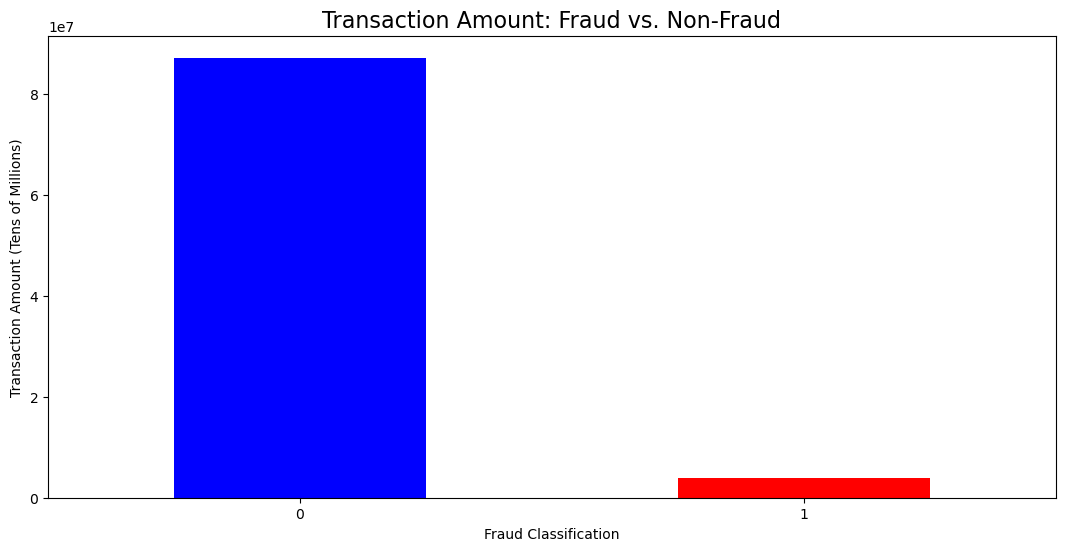

In [21]:
ax = fraud_amount.plot(kind='bar', rot=0,  color=['blue', 'red'], figsize=(13,6))

plt.xlabel('Fraud Classification')
plt.ylabel('Transaction Amount (Tens of Millions)')
ax.set_title('Transaction Amount: Fraud vs. Non-Fraud', fontsize=16)

plt.show()

In [22]:
fraud_amount_per = (fraud_amount / fraud_amount.sum() * 100).round(2)
fraud_amount_per

is_fraud
0    95.63
1     4.37
Name: amt, dtype: float64

**While it makes up over 4% of the transaction amount.** The 'is_fraud' column does not be adjusted. 

### Column - 'amt'

In [23]:
#looking further into transaction amount
amt = df['amt']
amt.describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [24]:
#for easier viewing
print(f"Min Transactional Amount ${amt.min():,.2f} and Max Transactional Amount ${amt.max():,.2f}")

Min Transactional Amount $1.00 and Max Transactional Amount $28,948.90


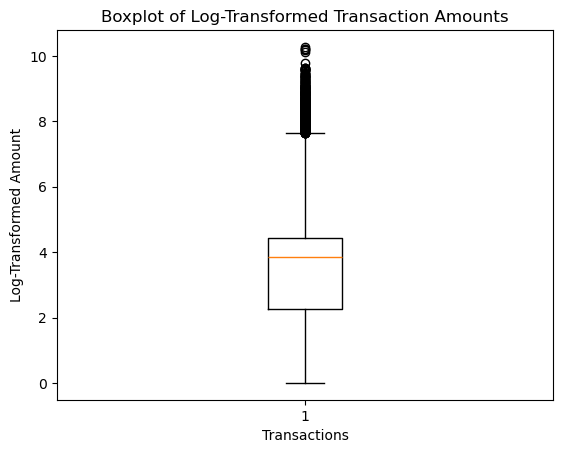

In [25]:
#applying a logarithmic transformation to the amount column for better visualization in the boxplot
amt_trans = np.log(amt[amt > 0])

#boxplot
plt.boxplot(amt_trans)
plt.xlabel('Transactions')
plt.ylabel('Log-Transformed Amount')
plt.title('Boxplot of Log-Transformed Transaction Amounts')
plt.show()

This plot highlights a relatively large number of outliers at the higher end of the transaction amounts. No issues requiring changes to the 'amt' column were identified at this stage.

### Column - 'category'

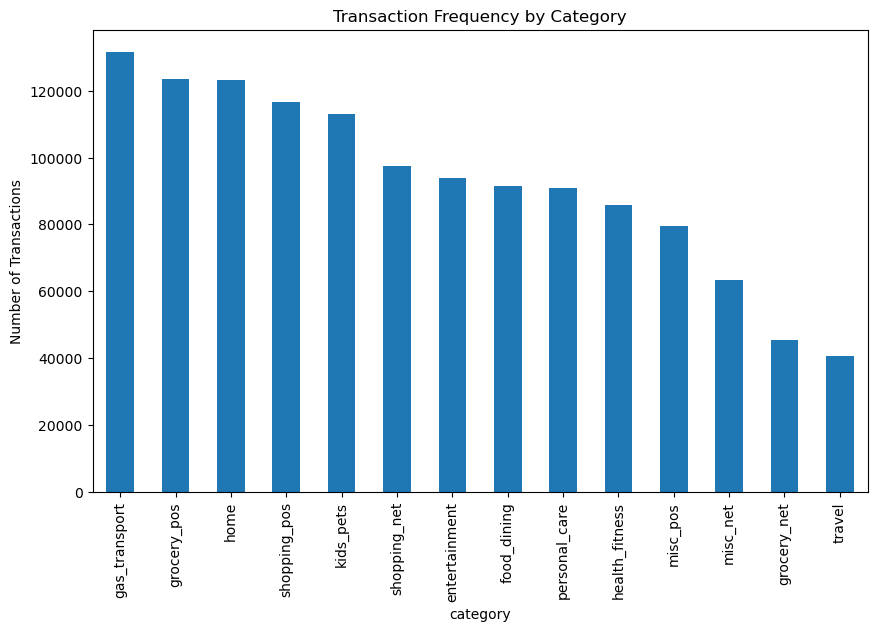

In [26]:
#plotting category frequency
df['category'].value_counts().plot(kind='bar', figsize=(10, 6), ylabel = 'Number of Transactions', title='Transaction Frequency by Category')
plt.show()

The 'category' column contains 14 unique values representing transaction types. Based on the names:

1. **Online Transactions:** Categories such as 'shopping_net', 'misc_net', and 'grocery_net' include 'net', likely indicating online transactions.
2. **In-Person Transactions:** Categories such as 'grocery_pos', 'shopping_pos', 'misc_pos', and 'gas_transport' include 'pos' or are typical in-person transactions (e.g., gas purchases).
3. **Unknown or Mixed:** Categories like 'home', 'kids_pets', 'entertainment', 'food_dining', 'personal_care', 'health_fitness', and 'travel' lack clear indicators and could represent either online or in-person transactions.

Additional research on Kaggle yielded no further details about the column's interpretation. This column will not be adjusted further, but ideas have been generated for potential new columns to be added during preprocessing.

### New Column Ideas
**Online/In-Person/Mixed Indicator**
- Name: 'transaction_type'
- Type: Category
- Values: 0: Unknown/Mixed, 1: Online, 2: In-Person

**Distance From Transaction to Card Holder**
- Distance between the transaction's latitude/longitude and the user's city/state coordinates
- Name: 'transactional_distance'
- Type: Float

**Merchant Distance**
- Distance between the merchant's latitude/longitude (merch_long, merch_lat) and the user's city/state.
- Name: 'merch_distance'
- Type: Float

**Location Match Indicator**
- Indicates whether the transaction location matches the user's city/state.
- Name: 'location_match'
- Type: Category
- Values: 0: Does not match, 1: Matches 

Processing resources and time will determine if columns are added. This will be researched further during feature creation. 

### Location Columns - 'lat', 'long', 'merch_lat', 'merch_long', 'city', 'state'

In [27]:
#shapefiles used for this process was downloaded from
#https://www.sciencebase.gov/catalog/item/5d150464e4b0941bde5b7654
map_file = r'C:\Users\eelil\OneDrive\Desktop\Capstone\Machine_Learning_Analysis_of_Bank_Fraud\map\US_Map_3'

In [28]:
#checking the ranges 
lat_long_columns = ['lat', 'long', 'merch_lat', 'merch_long']
df[lat_long_columns].describe()

,lat,long,merch_lat,merch_long
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,3.853762e+01,-9.022634e+01,3.853734e+01,-9.022646e+01
std,5.075808e+00,1.375908e+01,5.109788e+00,1.377109e+01
min,2.002710e+01,-1.656723e+02,1.902779e+01,-1.666712e+02
25%,3.462050e+01,-9.679800e+01,3.473357e+01,-9.689728e+01
50%,3.935430e+01,-8.747690e+01,3.936568e+01,-8.743839e+01
75%,4.194040e+01,-8.015800e+01,4.195716e+01,-8.023680e+01
max,6.669330e+01,-6.795030e+01,6.751027e+01,-6.695090e+01


In [29]:
#seeing the min and max values for each column 
for col in lat_long_columns:
    print(f"Smallest value {col} = {df[col].min()}") 
    print(f"Largest value {col} = {df[col].max()}") 

Smallest value lat = 20.0271
Largest value lat = 66.6933
Smallest value long = -165.6723
Largest value long = -67.9503
Smallest value merch_lat = 19.027785
Largest value merch_lat = 67.510267
Smallest value merch_long = -166.671242
Largest value merch_long = -66.950902


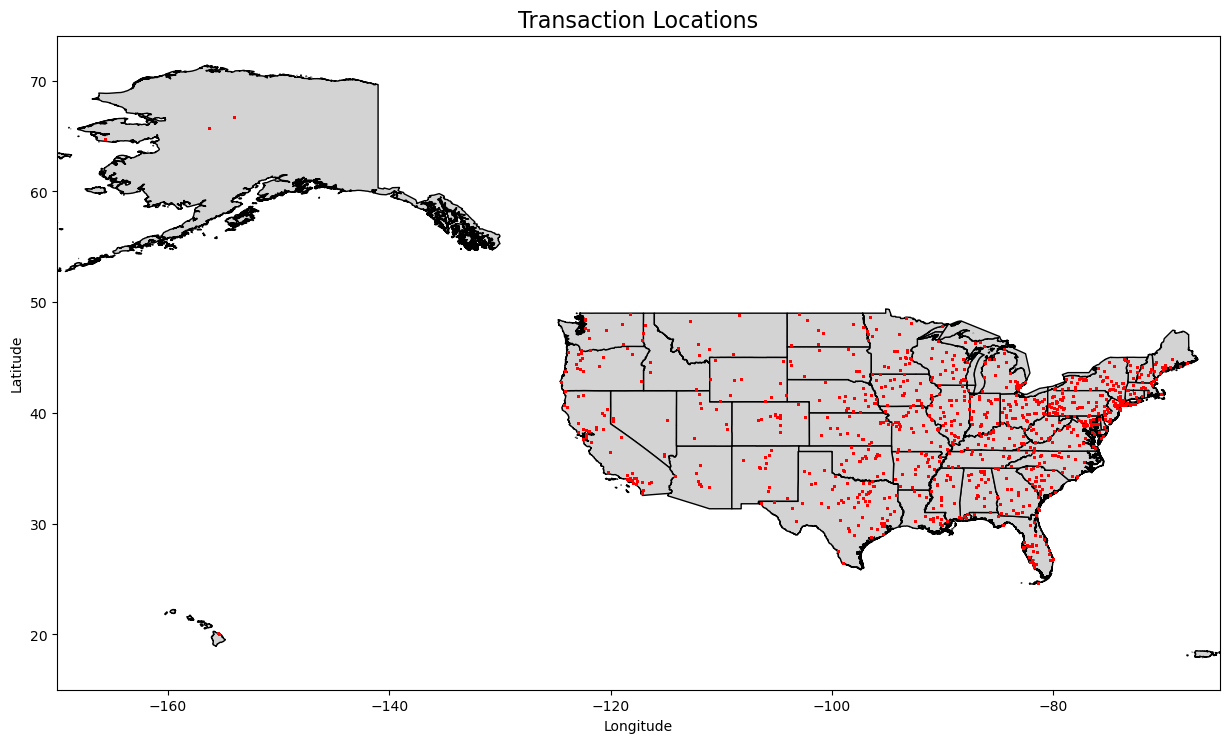

In [30]:
#plotting the transaction locations using 'long' and 'lat' columns
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
map = gpd.read_file(map_file)
ax = map.plot(color='lightgrey', edgecolor='black', figsize=(15,15))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gdf.plot(ax=ax, color='red', markersize=1)
plt.xlim(-170, -65)
ax.set_title('Transaction Locations', fontsize=16)
plt.show()

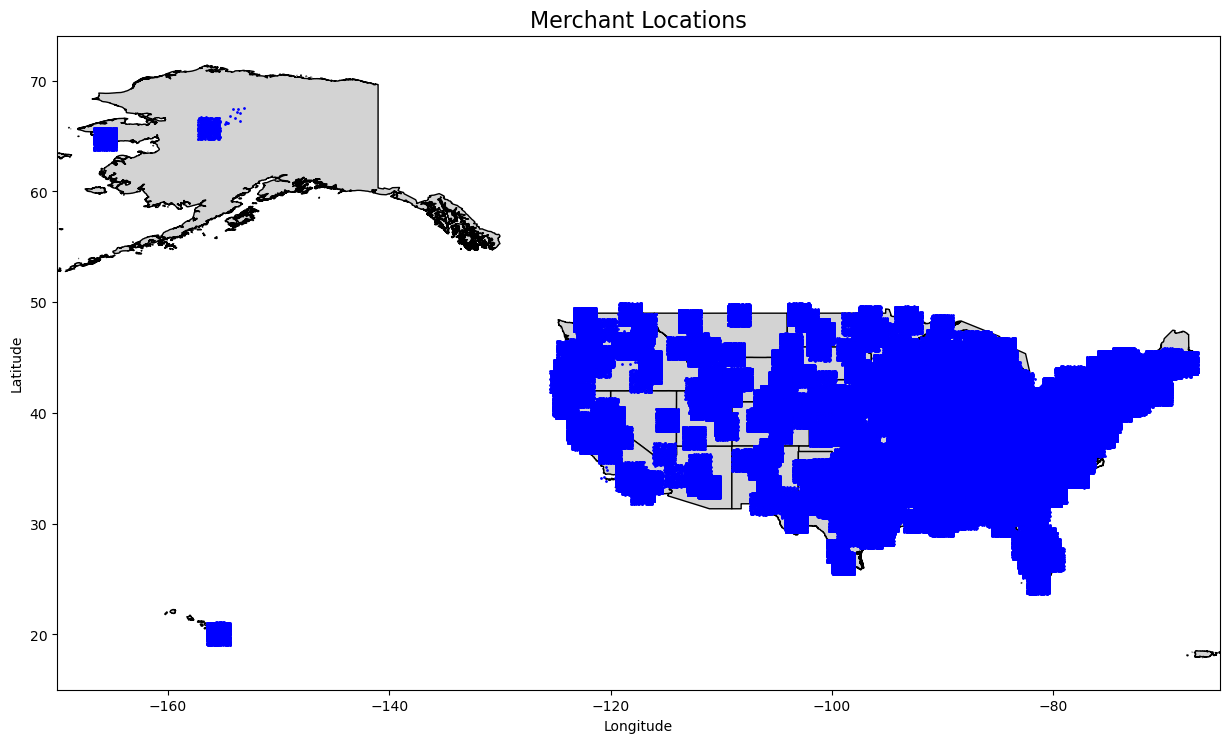

In [31]:
#plotting merchant locations using 'merch_long' and 'merch_lat' columns
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.merch_long, df.merch_lat))
map = gpd.read_file(map_file)
ax = map.plot(color='lightgrey', edgecolor='black', figsize=(15,15))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
gdf.plot(ax=ax, color='blue', markersize=1)
plt.xlim(-170, -65)
ax.set_title('Merchant Locations', fontsize=16)
plt.show()

In [32]:
#referencing the unique values for these columns
df[lat_long_columns].nunique()

lat               968
long              969
merch_lat     1247805
merch_long    1275745
dtype: int64

The data appears to have been anonymized or artificially generated, as indicated by the square clustering observed on the Merchant Locations map and the relatively low number of unique values in the 'lat' and 'long' columns. No adjustments will be made to these columns. 

In [33]:
#investigating customer location columns
cust_loc = ['city', 'state']
df[cust_loc].nunique()

city     894
state     51
dtype: int64

In [34]:
#checking state code values to see why it is 51
states = df['state'].unique()
states = states.tolist()
states.sort()
states

['AK',
 'AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'HI',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

In [35]:
#calculating unique city, state pair
loc_pairs = df[['city', 'state']].drop_duplicates()
loc_pairs.shape[0]

928

- The 'state' column has 50 US states and DC for Washington DC.
- The 'city' column has 894 unique values.
- There are 928 unique value pairs representing customer locations, so some cities share names, which might look like a false pattern. 
- There are 983 unique customer credit card numbers, so some cities have multiple customers.

#### New Column Ideas
**Latitude and Longitude for Customer's City**
- Name: 'cust_lat' & 'cust_long'
- Type: Float

Create two new columns, which will be populated based on the 'city' and 'state' pair vaules. Once created, the 'city' column can be dropped to prevent false patterns. No further changes will be made to the 'state' column. 

### Column - 'trans_date_trans_time'

In [36]:
#renaming 'trans_date_trans_time' column to something easier
df.rename(columns={'trans_date_trans_time' : 'trans_dt'}, inplace=True)
df.columns

Index(['trans_dt', 'cc_num', 'merchant', 'category', 'amt', 'city', 'state',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [37]:
#calculating date ranges
(df['trans_dt'].min(), df['trans_dt'].max())

(Timestamp('2019-01-01 00:00:18'), Timestamp('2020-06-21 12:13:37'))

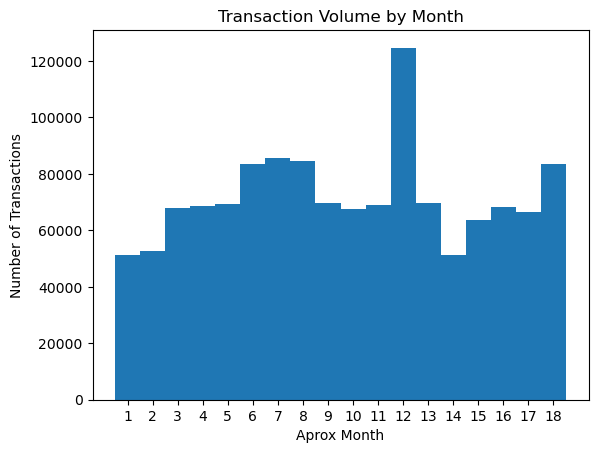

In [38]:
#creating a quick and easy viz of transactions over time
#using bins=18 so there can be approximately 1 bin for each month
#this isn't accurately separated by month, using this for ideas
n, bins, patches = plt.hist(df['trans_dt'], bins=18)

labels = np.arange(1, 19)
midpoints = (bins[:-1] + bins[1:]) / 2
plt.xticks(ticks=midpoints, labels=labels)

plt.title('Transaction Volume by Month')
plt.ylabel('Number of Transactions')
plt.xlabel('Aprox Month')

plt.show()

From this plot, we can roughly see that transaction volume can vary from month to month. 

In [39]:
df['trans_dt'].head(10)

0   2019-01-01 00:00:18
1   2019-01-01 00:00:44
2   2019-01-01 00:00:51
3   2019-01-01 00:01:16
4   2019-01-01 00:03:06
5   2019-01-01 00:04:08
6   2019-01-01 00:04:42
7   2019-01-01 00:05:08
8   2019-01-01 00:05:18
9   2019-01-01 00:06:01
Name: trans_dt, dtype: datetime64[ns]

  
The 'trans_dt' column has a lot of data packed into every field. The format is Year - Month - Day - Hour - Minute - Second. I want to create new columns.

### New Column Ideas
**Separate fields for Date, Year, Month, Day**
- Name: 'date', 'year', 'month', 'day'
- Type: Various
- To analyze specific transaction patterns by specific date and time components. 

**Week & Quarter**
- Name: 'week' & 'quarter'
- Type: Category
- To analyze seasonal patterns and time-related outliers. 

**Running Transaction Averages and Counts**
- Name: 'trans_by_last_hr', 'hourly_trans_avg','trans_by_last_day', 'daily_trans_avg', 'amt_last_hour', 'amt_last_day', 'avg_hr_amt', 'avg_daily_amt'
- Type: Float
- To track spending patterns for individual customers, enabling the detection of unusual spikes in transaction frequency or amount. 

### Column - 'cc_num'

In [40]:
#getting the number of transaction for each cc account
cc_counts = df.groupby('cc_num', observed=True).size()

In [41]:
#the number of unique accounts
df['cc_num'].nunique()

983

In [42]:
cc_counts.describe()

count     983.000000
mean     1319.099695
std       812.235900
min         7.000000
25%       525.000000
50%      1054.000000
75%      2025.000000
max      3123.000000
dtype: float64

This dataset has records for 983 customer, and number of transactions a single customer makes ranges from 7 to 3,123. 

In [43]:
#sorting the values 
sorted_cc = cc_counts.sort_values()

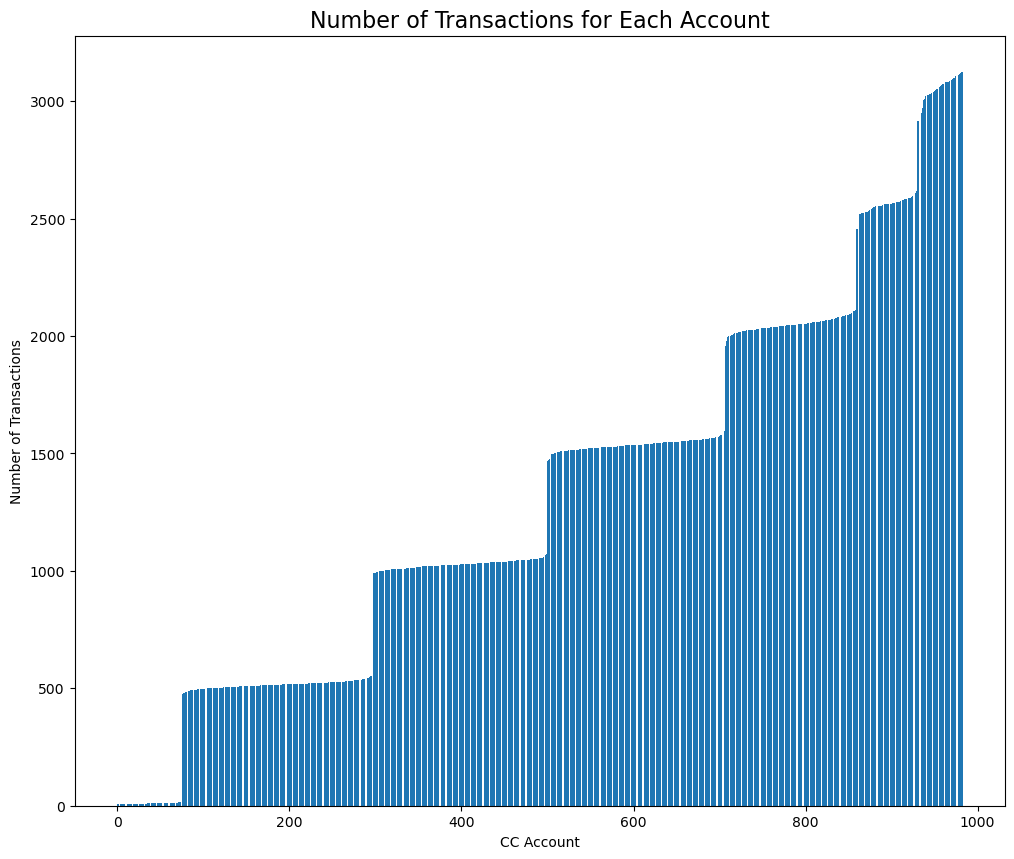

In [44]:
#plotting the number of transactions for low to high to see
#if there are typical transaction rates
plt.figure(figsize=(12,10))
plt.bar(range(len(sorted_cc)), sorted_cc)
plt.xlabel('CC Account')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions for Each Account', fontsize=16)

plt.show()

The 'cc_num' column reveals that transaction frequencies tend to cluster together. No changes will be made to the 'cc_num' column, as it is needed for identifying individual customers. Plans to use this column for creating new features, such as transaction patterns and spending behaviors, have already been outlined.

### Column - 'merchant'

In [45]:
#creating a variable of merchant names and finding the number of merchants
merchants = df['merchant'].unique()
len(merchants)

693

In [46]:
#finding the number of transactions for each merchant
merchant_count = df['merchant'].value_counts()
merchant_count.describe()

count     693.000000
mean     1871.103896
std       575.359948
min       727.000000
25%      1592.000000
50%      1863.000000
75%      2345.000000
max      4403.000000
Name: count, dtype: float64

The range of transaction frequency by merchant range from 727 to 4403. 

In [47]:
#calculating the high and low monitary amount per merchant
merchant_amount = df.groupby('merchant', observed=True)['amt'].sum()
merchant_amount = merchant_amount.sort_values()

In [48]:
#the ten merchants with the lowest amount
low = merchant_amount.head(10)
low

merchant
fraud_Bahringer-Larson                44227.23
fraud_Kohler, Lindgren and Koelpin    44704.41
fraud_Trantow PLC                     46397.34
fraud_Ortiz Group                     46451.33
fraud_Pfeffer LLC                     46484.86
fraud_McCullough Group                46522.70
fraud_Cummings Group                  46802.62
fraud_Hills-Olson                     46877.62
fraud_Swift, Bradtke and Marquardt    47120.59
fraud_Funk Group                      47352.15
Name: amt, dtype: float64

In [49]:
#the ten merchants with the highest amounts
high = merchant_amount.tail(10)
high

merchant
fraud_Bauch-Raynor                  295721.20
fraud_Murray-Smitham                296982.73
fraud_Pacocha-O'Reilly              297584.38
fraud_Goodwin-Nitzsche              298083.31
fraud_Rau and Sons                  298354.77
fraud_Schumm, Bauch and Ondricka    299115.14
fraud_Hackett-Lueilwitz             300208.14
fraud_Doyle Ltd                     300971.37
fraud_Bradtke PLC                   302481.25
fraud_Kilback LLC                   391078.15
Name: amt, dtype: float64

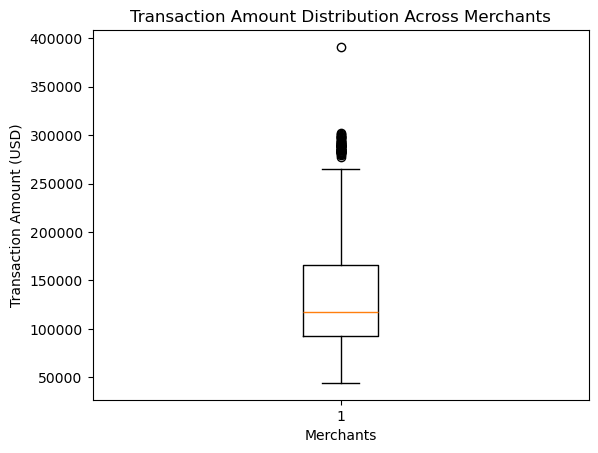

In [50]:
#box plot showing the range
plt.boxplot(merchant_amount)
plt.xlabel('Merchants')
plt.ylabel('Transaction Amount (USD)')
plt.title('Transaction Amount Distribution Across Merchants')
plt.show()

This plot shows that merchant transaction amounts can vary significantly from one merchant to the next, as does the number of transactions per merchant. This column will not be adjusted at this time. 

### Column - 'city_pop'

In [51]:
#checking unique values
pop_values = df['city_pop'].drop_duplicates()
pop_values.shape[0]

879

In [52]:
#checking unique city, state, city_pop values
pop_triad = df[['city', 'state', 'city_pop']].drop_duplicates()
pop_triad.shape[0]

928

There are 879 unique city population values but 928 unique customer locations, so some cities have the same population value. 

In [53]:
#looking at the low and high city populations 
pop_city = pop_triad.sort_values(by='city_pop')
pop_city

,city,state,city_pop
476,Notrees,TX,23
425,Gregory,AR,37
436,Ratcliff,TX,43
42,Thompson,UT,46
14865,West Bethel,ME,47
...,...,...,...
105,New York City,NY,1577385
210,San Antonio,TX,1595797
7244,Los Angeles,CA,2383912
1977,Brooklyn,NY,2504700


The city_pop column displays a wide variation, with values ranging from 23 to 2,906,700. Concerned about potential inaccuracies, I conducted further investigation. A cursory search for Notrees, Texas, found its population to be approximately 20 in 2009, aligning closely with the dataset. However, another search for West Bethel, ME, revealed a significant discrepancy, as its population was 2,504 according to [Wikipedia](https://en.wikipedia.org/wiki/Bethel,_Maine). Similar inconsistencies were found for other cities. Given the unreliable nature of the city_pop data, I have decided to drop this column from the analysis.

### Column - 'job'

In [54]:
#checking how many unique values are in the 'job' column
df['job'] = df['job'].str.lower().str.strip()
df['job'].nunique()

494

In [55]:
#reducing data down to one transaction per account and job title 
jobs_db = df[['cc_num', 'job']].drop_duplicates()
jobs_db = jobs_db.sort_values(by='job')
jobs_db

,cc_num,job
3794,4383521454815,academic librarian
601865,3524485462198080,"accountant, chartered"
488,6011975266774121,"accountant, chartered certified"
975543,6500249000784905,"accountant, chartered certified"
1282,213191402330021,"accountant, chartered public finance"
...,...,...
991,4996263498048679,web designer
1722,30373802285317,wellsite geologist
267,343819048608995,wellsite geologist
552,4220495028289516646,wellsite geologist


In [56]:
#seeing how many customers have the same job title
job_count = jobs_db['job'].value_counts()
job_count.describe()

count    494.000000
mean       1.989879
std        1.087407
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: count, dtype: float64

In [57]:
#each job title
jobs = jobs_db['job'].drop_duplicates()
len(jobs)

494

In [58]:
#checking how many skills have similar names using rapid fuzz
similar_jobs = []

for i, job in enumerate(jobs):
    matches = process.extract(job, jobs[i+1:], scorer=fuzz.token_sort_ratio, limit=10)
    for match in matches:
        if match[1] >= 80:  #has similarity score of at least 80
            similar_jobs.append((job, match[0], match[1]))

len(similar_jobs)#seeing how many matches

144

In [59]:
#looking at the matching jobs
similar_jobs

[('academic librarian', 'librarian, academic', 97.2972972972973),
 ('accountant, chartered', 'chartered accountant', 97.5609756097561),
 ('accountant, chartered',
  'accountant, chartered certified',
  80.76923076923077),
 ('accountant, chartered public finance',
  'chartered public finance accountant',
  98.59154929577466),
 ('administrator', 'administrator, arts', 81.25),
 ('administrator, arts', 'sports administrator', 87.17948717948718),
 ('administrator, arts', 'database administrator', 82.92682926829268),
 ('administrator, education', 'education administrator', 97.87234042553192),
 ('advertising copywriter', 'copywriter, advertising', 97.77777777777777),
 ('aeronautical engineer', 'engineer, aeronautical', 97.67441860465115),
 ('air cabin crew', 'cabin crew', 83.33333333333334),
 ('airline pilot', 'pilot, airline', 96.2962962962963),
 ('analytical chemist', 'chemist, analytical', 97.2972972972973),
 ('armed forces technical officer', 'medical technical officer', 80.0),
 ('art the

While the job names are very similar, the jobs with a score lower than 95 seem different, while the ones with a score higher than 95 seem to be the same job but written slightly differently. I will adjust the similarity score. 

In [60]:
#adjusting the similarity score
similar_jobs = []

for i, job in enumerate(jobs):
    matches = process.extract(job, jobs[i+1:], scorer=fuzz.token_sort_ratio, limit=10)
    for match in matches:
        if match[1] >= 95:  #has similarity score of at least 95
            similar_jobs.append((job, match[0], match[1]))

len(similar_jobs)#seeing how many matches

81

In [61]:
similar_jobs

[('academic librarian', 'librarian, academic', 97.2972972972973),
 ('accountant, chartered', 'chartered accountant', 97.5609756097561),
 ('accountant, chartered public finance',
  'chartered public finance accountant',
  98.59154929577466),
 ('administrator, education', 'education administrator', 97.87234042553192),
 ('advertising copywriter', 'copywriter, advertising', 97.77777777777777),
 ('aeronautical engineer', 'engineer, aeronautical', 97.67441860465115),
 ('airline pilot', 'pilot, airline', 96.2962962962963),
 ('analytical chemist', 'chemist, analytical', 97.2972972972973),
 ('art therapist', 'therapist, art', 96.2962962962963),
 ('audiological scientist', 'scientist, audiological', 97.77777777777777),
 ('biochemist, clinical', 'clinical biochemist', 97.43589743589743),
 ('biomedical engineer', 'engineer, biomedical', 97.43589743589743),
 ('biomedical scientist', 'scientist, biomedical', 97.5609756097561),
 ('building services engineer',
  'engineer, building services',
  98.113

In [62]:
job_count

job
copywriter, advertising      6
naval architect              6
quantity surveyor            6
materials engineer           6
trading standards officer    6
                            ..
immigration officer          1
illustrator                  1
hydrographic surveyor        1
hydrogeologist               1
writer                       1
Name: count, Length: 494, dtype: int64

The dataset has 494 unique job titles, with each title appearing one to six times. After sorting the column values, I noticed similar but slightly different job titles. I ran RapidFuzz with a similarity threshold of 80 to identify potential matches, but this resulted in overly broad groupings. To improve accuracy, I changed the similarity threshold to 95, which reduced the matches from 144 to 81. During the preprocessing phase, I plan to replace the less common variations of job titles with the most frequently used version for standardization.

### Column - 'dob'

In [63]:
#checking the range of values for date of birth
df['dob'].describe()

count                          1296675
mean     1973-10-03 19:02:55.017178512
min                1924-10-30 00:00:00
25%                1962-08-13 00:00:00
50%                1975-11-30 00:00:00
75%                1987-02-22 00:00:00
max                2005-01-29 00:00:00
Name: dob, dtype: object

One visible issue is that the maximum value for the date of birth is 2005-01-29. That would make the cardholder around 14 to 15 at the time of the transaction. This could be an indicator of fraud or an incorrect value. 

In [64]:
#grouping and sorting the birthday values for plotting
birthdays = df[['cc_num', 'dob']].drop_duplicates()
sorted_dob = birthdays.sort_values(by='dob')

In [65]:
#creating a year and decade column for easier plotting
birthdays['year'] = birthdays['dob'].dt.year
birthdays['decade'] = (birthdays['year'] // 10) * 10

In [66]:
#grouping every ten years together
decade_counts = birthdays.groupby('decade').size()

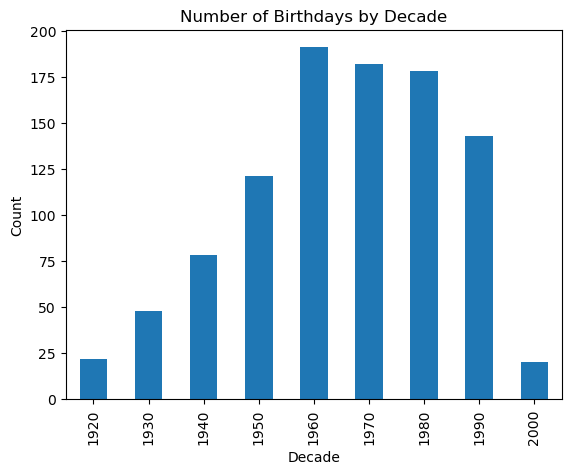

In [67]:
decade_counts.plot(kind='bar')
plt.title('Number of Birthdays by Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.show()

This plot highlights that the majority of account holders were born between the 1960s and 1990s. Birthdays at either extreme could indicate potential fraud, especially for account holders under 18 at the time of the transaction.

**New Column Idea**
- Name: 'age_at_trans'
- Type: Float
- This column will have the customer's age (in years) at the time of the transaction to see if it is an indicator of fraud.


---
### Summary

I analyzed the dataset to identify its structure, assess the quality, and generate ideas for preprocessing and feature engineering. From this process, I determined: 

#### **Data Cleaning and Preparation**

1. **Column Renaming**:
   - 'trans_date_trans_time' will be renamed to 'trans_dt'.
  
2. **Columns to Drop**:
   - **Before feature creation**: 'unnamed', 'first', 'last', 'gender', 'street', 'zip', 'merch_zipcode', 'unix_time', and 'city_pop'. 
   - **After creating features**: 'city'.
  
3. **Data Type Adjustments**:
   - Convert to datetime: 'trans_dt', 'dob'.
   - Convert to category: 'merchant', 'category', 'city', 'state', 'job', 'is_fraud'.
  
4. **Duplicates**:
   - No duplicate rows were found in the dataset.
  
#### **Insights from Data Analysis**

1. **Fraudulent Transactions**:
   - Less than 1% of transactions are fraudulent but account for over 4% of the transaction amount.
   - 'is_fraud' column will not be adjusted.

2. **Transaction Amounts (amt)**:
   - Range: $1.00 to $28,948.90.
   - The column contains outliers at the higher end, but no adjustments will be made. 

3. **Transaction Categories**:
   - 14 unique categories with potential to classify transactions as online, in-person, or mixed based on naming conventions.
   - No further changes to the column, but a new "transaction_type" column will be added.

4. **Location Data**:
- Latitude and longitude values for both transactions and merchants suggest anonymization due to square clustering or a low number of unique values.
- **Range of values**:
    - **Transaction** latitudes: 20.0271 to 66.6933, longitudes: -165.6723 to -67.9503.
    - **Merchant** latitudes: 19.027785 to 67.510267, longitudes: -166.671242 to -66.950902.
- Columns remain unchanged, but new features such as 'merch_distance' and 'location_match' will be added.

5. **City Population (city_pop)**:
   - Values range from 23 to 2,906,700 across 879 unique entries. However, several inconsistencies were identified during validation.
   - The column will be dropped due to unreliablity.

6. **Job Titles (job)**:
   - 494 unique job titles with inconsistencies in naming conventions.
   - During preprocessing, less common variations will be replaced with their most frequently used counterparts using a similarity threshold of 95 in RapidFuzz.

7. **Birth Dates (dob)**:
   - Majority of account holders were born between the 1960s and 1990s.
   - Extreme birth dates could indicate potential fraud, especially for account holders under 18 at the time of the transaction.

8. **Credit Card Numbers (cc_num)**:
   - Range: 7 to 3,123 transactions per customer.
   - No adjustments planned, as this column is needed for identifying patterns in spending behaviors.

#### **Potential New Features**
- **Transaction Features**: 'transaction_type', 'trans_by_last_hr', 'hourly_trans_avg', 'trans_by_last_day', 'daily_trans_avg', 'amt_last_hour', 'amt_last_day', 'avg_hr_amt', 'avg_daily_amt'.
- **Location Features**: 'merch_distance', 'location_match', 'cust_lat', 'cust_long'.
- **Time Features**: 'date', 'year', 'month', 'day', 'week', 'quarter'.
- **Age Feature**: "age_at_trans", representing the customer's age at the time of the transaction (float).

#### **Transaction Timeline**
- **Data spans**: January 1, 2019, to June 21, 2020.
- **Counts**:
  - Customers: 983.
  - Merchants: 693.
- **Transaction frequency**:
  - Customers: 7 to 3,123 transactions.
  - Merchants: 727 to 4,403 transactions.

This comprehensive understanding of the dataset lays the foundation for effective preprocessing, feature engineering, and model development in subsequent phases.


### Sources

Choksi, P. (n.d.). Credit card transactions dataset: Using transactional data for financial analysis and fraud detection. Kaggle. Retrieved November 21, 2024, from https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset

National Atlas of the United States. (2014). 1:1,000,000-Scale State Boundaries of the United States [Vector digital data]. Rolla, MO: National Atlas of the United States. Retrieved from https://www.sciencebase.gov/catalog/item/581d052de4b08da350d524e5

Wikipedia contributors. (n.d.). Bethel, Maine. In Wikipedia. Retrieved December 6, 2024, from https://en.wikipedia.org/wiki/Bethel,_Maine